## GAN
https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/ 
https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

60000
10000


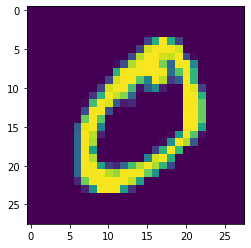

In [13]:
from numpy import load
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf


(train_images, train_labels), (test_images, test_labels)  = tf.keras.datasets.mnist.load_data(path="mnist.npz") 
#numbers = data['arr_0']
# assert x_train.shape == (60000, 28, 28)
# assert x_test.shape == (10000, 28, 28)
# assert y_train.shape == (60000,)
# assert y_test.shape == (10000,)
print(len(train_images))
print(len(test_images))

train_images[1].shape
plt.imshow(train_images[1])

In [21]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
 
# define the standalone discriminator model
def define_discriminator(in_shape=(80,80,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(128, (5,5), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 40x40
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 20x30
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 10x10
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 5x5
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model
 
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 5x5 feature maps
	n_nodes = 128 * 5 * 5
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((5, 5, 128)))
	# upsample to 10x10
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 20x20
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 40x40
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 80x80
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer 80x80x3
	model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 

#(train_images, train_labels), (test_images, test_labels)  = tf.keras.datasets.mnist.load_data(path="mnist.npz")     
# load and prepare training images
def load_real_samples():
	# load the face dataset
	#data = load('mnist.npz')
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data(path="mnist.npz")
    X = train_images.reshape(-1, 28, 28, 1)
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y
 
# create and save a plot of generated images
def save_plot(examples, epoch, n=10):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()
 
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
 
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

ValueError: in user code:

    /home/marusya/miniconda3/envs/ocv/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/marusya/miniconda3/envs/ocv/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/marusya/miniconda3/envs/ocv/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/marusya/miniconda3/envs/ocv/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/marusya/miniconda3/envs/ocv/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/marusya/miniconda3/envs/ocv/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/marusya/miniconda3/envs/ocv/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/marusya/miniconda3/envs/ocv/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/marusya/miniconda3/envs/ocv/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_12 is incompatible with the layer: expected axis -1 of input shape to have value 3 but received input with shape (64, 28, 28, 1)


In [22]:

# example of loading the mnist dataset
from keras.datasets.mnist import load_data
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


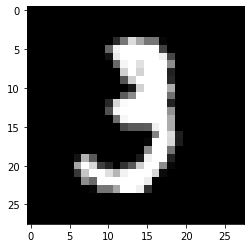

In [28]:
# plot raw pixel data
pyplot.imshow(trainX[10], cmap='gray')# plot raw pixel data

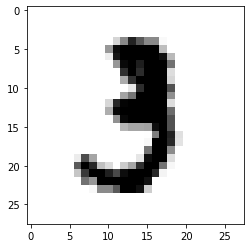

In [30]:
# plot raw pixel data
pyplot.imshow(trainX[10], cmap='gray_r')

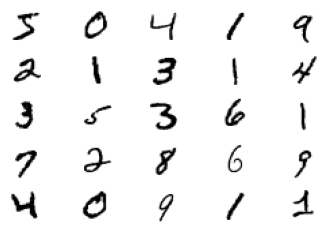

In [31]:
# example of loading the mnist dataset
from keras.datasets.mnist import load_data
from matplotlib import pyplot
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# plot images from the training dataset
for i in range(25):
	# define subplot
	pyplot.subplot(5, 5, 1 + i)
	# turn off axis
	pyplot.axis('off')
	# plot raw pixel data
	pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()

Inputs: Image with one channel and 28×28 pixels in size.
Outputs: Binary classification, likelihood the sample is real (or fake).
A plot of the model is also created and we can see that the model expects two inputs and will predict a single output.
We could start training this model now with real examples with a class label of one, and randomly generated samples with a class label of zero.
The images are 2D arrays of pixels and convolutional neural networks expect 3D arrays of images as input, where each image has one or more channels.


In [32]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
 
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model
 
# define model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_50 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_51 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3136)            

In [38]:
# load mnist dataset
(trainX, _), (_, _) = load_data()

import numpy as np
# expand to 3d, e.g. add channels dimension
X = np.expand_dims(trainX, axis=-1)


# convert from unsigned ints to floats
X = X.astype('float32')
# scale from [0,255] to [0,1]
X = X / 255.0

In [ ]:

# load and prepare mnist training images (copies above code)
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X


# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y


# generate n fake samples with class labels
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = rand(28 * 28 * n_samples)
	# reshape into a batch of grayscale images
	X = X.reshape((n_samples, 28, 28, 1))
	# generate 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [ ]:

# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [ ]:

# example of training the discriminator model on real and random mnist images
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
 
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model
 
# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y
 
# generate n fake samples with class labels
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = rand(28 * 28 * n_samples)
	# reshape into a batch of grayscale images
	X = X.reshape((n_samples, 28, 28, 1))
	# generate 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y
 
# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))
 
# define the discriminator model
model = define_discriminator()
# load image data
dataset = load_real_samples()
# fit the model
train_discriminator(model, dataset)

## Generator
The latent space is an arbitrarily defined vector space of Gaussian-distributed values, e.g. 100 dimensions. It has no meaning, but by drawing points from this space randomly and providing them to the generator model during training, the generator model will assign meaning to the latent points and, in turn, the latent space, until, at the end of training, the latent vector space represents a compressed representation of the output space, MNIST images, that only the generator knows how to turn into plausible MNIST images.

Inputs: Point in latent space, e.g. a 100 element vector of Gaussian random numbers.
Outputs: Two-dimensional square grayscale image of 28×28 pixels with pixel values in [0,1].

Note: we don’t have to use a 100 element vector as input; it is a round number and widely used, but I would expect that 10, 50, or 500 would work just as well.

Note: the generator model is not compiled and does not specify a loss function or optimization algorithm. This is because the generator is not trained directly.

In [39]:

# example of defining the generator model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
 
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model
 
# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_52 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_20 (Conv2DT (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_54 (LeakyReLU)   (None, 28, 28, 128)     

2022-05-26 12:55:22.454664: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-26 12:55:22.467457: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2711995000 Hz


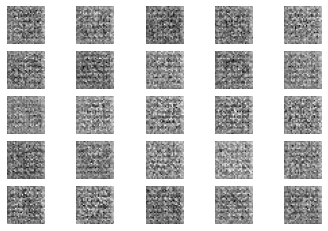

In [40]:

# example of defining and using the generator model
from numpy import zeros
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from matplotlib import pyplot
 
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y
 
# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
	# define subplot
	pyplot.subplot(5, 5, 1 + i)
	# turn off axis labels
	pyplot.axis('off')
	# plot single image
	pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
pyplot.show()

In [41]:

# demonstrate creating the three models in the gan
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.utils.vis_utils import plot_model
 
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model
 
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_19 (Sequential)   (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_18 (Sequential)   (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [ ]:

# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=100, n_batch=256):
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)

In [ ]:

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

In [ ]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()


# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)

In [42]:

# example of training a gan on mnist
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
 
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model
 
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 
# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y
 
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()
 
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
 
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

>1, 1/234, d=0.690, g=0.716
>1, 2/234, d=0.688, g=0.738
>1, 3/234, d=0.675, g=0.754
>1, 4/234, d=0.668, g=0.769
>1, 5/234, d=0.662, g=0.779
>1, 6/234, d=0.658, g=0.800
>1, 7/234, d=0.650, g=0.809
>1, 8/234, d=0.645, g=0.819
>1, 9/234, d=0.642, g=0.829
>1, 10/234, d=0.639, g=0.825
>1, 11/234, d=0.642, g=0.823
>1, 12/234, d=0.640, g=0.809
>1, 13/234, d=0.646, g=0.791
>1, 14/234, d=0.649, g=0.770
>1, 15/234, d=0.652, g=0.747
>1, 16/234, d=0.653, g=0.730
>1, 17/234, d=0.653, g=0.717
>1, 18/234, d=0.647, g=0.707
>1, 19/234, d=0.646, g=0.701
>1, 20/234, d=0.643, g=0.697
>1, 21/234, d=0.637, g=0.694
>1, 22/234, d=0.629, g=0.693
>1, 23/234, d=0.622, g=0.692
>1, 24/234, d=0.615, g=0.692
>1, 25/234, d=0.604, g=0.694
>1, 26/234, d=0.594, g=0.694
>1, 27/234, d=0.593, g=0.695
>1, 28/234, d=0.580, g=0.697
>1, 29/234, d=0.566, g=0.698
>1, 30/234, d=0.553, g=0.699
>1, 31/234, d=0.544, g=0.700
>1, 32/234, d=0.539, g=0.702
>1, 33/234, d=0.524, g=0.703
>1, 34/234, d=0.517, g=0.704
>1, 35/234, d=0.510, g=

>2, 46/234, d=0.686, g=0.757
>2, 47/234, d=0.669, g=0.749
>2, 48/234, d=0.691, g=0.739
>2, 49/234, d=0.707, g=0.731
>2, 50/234, d=0.710, g=0.716
>2, 51/234, d=0.710, g=0.720
>2, 52/234, d=0.702, g=0.723
>2, 53/234, d=0.717, g=0.715
>2, 54/234, d=0.706, g=0.717
>2, 55/234, d=0.688, g=0.688
>2, 56/234, d=0.706, g=0.712
>2, 57/234, d=0.692, g=0.708
>2, 58/234, d=0.686, g=0.694
>2, 59/234, d=0.680, g=0.726
>2, 60/234, d=0.692, g=0.737
>2, 61/234, d=0.701, g=0.737
>2, 62/234, d=0.700, g=0.741
>2, 63/234, d=0.715, g=0.745
>2, 64/234, d=0.699, g=0.743
>2, 65/234, d=0.692, g=0.737
>2, 66/234, d=0.697, g=0.742
>2, 67/234, d=0.682, g=0.749
>2, 68/234, d=0.706, g=0.752
>2, 69/234, d=0.677, g=0.772
>2, 70/234, d=0.696, g=0.779
>2, 71/234, d=0.685, g=0.777
>2, 72/234, d=0.690, g=0.766
>2, 73/234, d=0.679, g=0.774
>2, 74/234, d=0.679, g=0.778
>2, 75/234, d=0.686, g=0.776
>2, 76/234, d=0.684, g=0.738
>2, 77/234, d=0.694, g=0.785
>2, 78/234, d=0.701, g=0.747
>2, 79/234, d=0.691, g=0.753
>2, 80/234, d=

>3, 91/234, d=0.696, g=0.714
>3, 92/234, d=0.700, g=0.720
>3, 93/234, d=0.690, g=0.720
>3, 94/234, d=0.713, g=0.728
>3, 95/234, d=0.723, g=0.715
>3, 96/234, d=0.706, g=0.707
>3, 97/234, d=0.721, g=0.709
>3, 98/234, d=0.714, g=0.705
>3, 99/234, d=0.714, g=0.714
>3, 100/234, d=0.712, g=0.712
>3, 101/234, d=0.719, g=0.711
>3, 102/234, d=0.726, g=0.715
>3, 103/234, d=0.719, g=0.717
>3, 104/234, d=0.708, g=0.710
>3, 105/234, d=0.709, g=0.709
>3, 106/234, d=0.712, g=0.704
>3, 107/234, d=0.714, g=0.710
>3, 108/234, d=0.698, g=0.703
>3, 109/234, d=0.707, g=0.703
>3, 110/234, d=0.698, g=0.712
>3, 111/234, d=0.703, g=0.719
>3, 112/234, d=0.694, g=0.733
>3, 113/234, d=0.686, g=0.727
>3, 114/234, d=0.684, g=0.738
>3, 115/234, d=0.690, g=0.743
>3, 116/234, d=0.687, g=0.738
>3, 117/234, d=0.669, g=0.749
>3, 118/234, d=0.680, g=0.741
>3, 119/234, d=0.666, g=0.747
>3, 120/234, d=0.667, g=0.755
>3, 121/234, d=0.664, g=0.748
>3, 122/234, d=0.660, g=0.750
>3, 123/234, d=0.659, g=0.763
>3, 124/234, d=0.65

>4, 134/234, d=0.715, g=0.694
>4, 135/234, d=0.720, g=0.703
>4, 136/234, d=0.701, g=0.718
>4, 137/234, d=0.708, g=0.719
>4, 138/234, d=0.703, g=0.719
>4, 139/234, d=0.707, g=0.715
>4, 140/234, d=0.708, g=0.707
>4, 141/234, d=0.696, g=0.699
>4, 142/234, d=0.712, g=0.694
>4, 143/234, d=0.698, g=0.699
>4, 144/234, d=0.714, g=0.695
>4, 145/234, d=0.691, g=0.697
>4, 146/234, d=0.703, g=0.703
>4, 147/234, d=0.698, g=0.697
>4, 148/234, d=0.695, g=0.699
>4, 149/234, d=0.688, g=0.712
>4, 150/234, d=0.685, g=0.700
>4, 151/234, d=0.698, g=0.718
>4, 152/234, d=0.684, g=0.720
>4, 153/234, d=0.686, g=0.730
>4, 154/234, d=0.694, g=0.719
>4, 155/234, d=0.694, g=0.721
>4, 156/234, d=0.692, g=0.718
>4, 157/234, d=0.689, g=0.701
>4, 158/234, d=0.692, g=0.703
>4, 159/234, d=0.696, g=0.697
>4, 160/234, d=0.686, g=0.702
>4, 161/234, d=0.699, g=0.707
>4, 162/234, d=0.701, g=0.708
>4, 163/234, d=0.689, g=0.710
>4, 164/234, d=0.704, g=0.711
>4, 165/234, d=0.717, g=0.707
>4, 166/234, d=0.697, g=0.696
>4, 167/23

>5, 177/234, d=0.688, g=0.714
>5, 178/234, d=0.679, g=0.719
>5, 179/234, d=0.687, g=0.711
>5, 180/234, d=0.691, g=0.721
>5, 181/234, d=0.684, g=0.703
>5, 182/234, d=0.675, g=0.717
>5, 183/234, d=0.693, g=0.714
>5, 184/234, d=0.680, g=0.699
>5, 185/234, d=0.682, g=0.716
>5, 186/234, d=0.685, g=0.722
>5, 187/234, d=0.688, g=0.726
>5, 188/234, d=0.684, g=0.719
>5, 189/234, d=0.693, g=0.715
>5, 190/234, d=0.684, g=0.711
>5, 191/234, d=0.685, g=0.709
>5, 192/234, d=0.681, g=0.691
>5, 193/234, d=0.691, g=0.695
>5, 194/234, d=0.702, g=0.714
>5, 195/234, d=0.688, g=0.706
>5, 196/234, d=0.685, g=0.714
>5, 197/234, d=0.695, g=0.707
>5, 198/234, d=0.686, g=0.712
>5, 199/234, d=0.688, g=0.714
>5, 200/234, d=0.686, g=0.720
>5, 201/234, d=0.690, g=0.707
>5, 202/234, d=0.695, g=0.698
>5, 203/234, d=0.694, g=0.704
>5, 204/234, d=0.698, g=0.702
>5, 205/234, d=0.693, g=0.704
>5, 206/234, d=0.703, g=0.691
>5, 207/234, d=0.686, g=0.699
>5, 208/234, d=0.699, g=0.688
>5, 209/234, d=0.688, g=0.698
>5, 210/23

>6, 220/234, d=0.670, g=0.726
>6, 221/234, d=0.675, g=0.728
>6, 222/234, d=0.681, g=0.726
>6, 223/234, d=0.687, g=0.718
>6, 224/234, d=0.684, g=0.706
>6, 225/234, d=0.685, g=0.704
>6, 226/234, d=0.691, g=0.692
>6, 227/234, d=0.686, g=0.678
>6, 228/234, d=0.681, g=0.669
>6, 229/234, d=0.693, g=0.673
>6, 230/234, d=0.696, g=0.674
>6, 231/234, d=0.699, g=0.683
>6, 232/234, d=0.694, g=0.697
>6, 233/234, d=0.694, g=0.716
>6, 234/234, d=0.695, g=0.719
>7, 1/234, d=0.700, g=0.726
>7, 2/234, d=0.699, g=0.729
>7, 3/234, d=0.704, g=0.717
>7, 4/234, d=0.712, g=0.704
>7, 5/234, d=0.707, g=0.684
>7, 6/234, d=0.711, g=0.683
>7, 7/234, d=0.705, g=0.673
>7, 8/234, d=0.700, g=0.664
>7, 9/234, d=0.707, g=0.668
>7, 10/234, d=0.707, g=0.667
>7, 11/234, d=0.707, g=0.685
>7, 12/234, d=0.713, g=0.699
>7, 13/234, d=0.704, g=0.710
>7, 14/234, d=0.701, g=0.725
>7, 15/234, d=0.710, g=0.726
>7, 16/234, d=0.703, g=0.710
>7, 17/234, d=0.709, g=0.706
>7, 18/234, d=0.702, g=0.702
>7, 19/234, d=0.713, g=0.693
>7, 20/2

>8, 30/234, d=0.662, g=0.652
>8, 31/234, d=0.680, g=0.645
>8, 32/234, d=0.680, g=0.624
>8, 33/234, d=0.699, g=0.627
>8, 34/234, d=0.702, g=0.634
>8, 35/234, d=0.719, g=0.675
>8, 36/234, d=0.707, g=0.737
>8, 37/234, d=0.703, g=0.810
>8, 38/234, d=0.699, g=0.848
>8, 39/234, d=0.681, g=0.879
>8, 40/234, d=0.674, g=0.885
>8, 41/234, d=0.686, g=0.841
>8, 42/234, d=0.684, g=0.797
>8, 43/234, d=0.698, g=0.754
>8, 44/234, d=0.698, g=0.724
>8, 45/234, d=0.703, g=0.691
>8, 46/234, d=0.696, g=0.678
>8, 47/234, d=0.696, g=0.672
>8, 48/234, d=0.687, g=0.668
>8, 49/234, d=0.684, g=0.661
>8, 50/234, d=0.681, g=0.646
>8, 51/234, d=0.684, g=0.647
>8, 52/234, d=0.696, g=0.642
>8, 53/234, d=0.697, g=0.650
>8, 54/234, d=0.697, g=0.660
>8, 55/234, d=0.705, g=0.680
>8, 56/234, d=0.700, g=0.699
>8, 57/234, d=0.697, g=0.728
>8, 58/234, d=0.696, g=0.747
>8, 59/234, d=0.690, g=0.761
>8, 60/234, d=0.685, g=0.771
>8, 61/234, d=0.692, g=0.768
>8, 62/234, d=0.691, g=0.756
>8, 63/234, d=0.699, g=0.737
>8, 64/234, d=

>9, 75/234, d=0.691, g=0.687
>9, 76/234, d=0.690, g=0.692
>9, 77/234, d=0.688, g=0.701
>9, 78/234, d=0.695, g=0.701
>9, 79/234, d=0.693, g=0.716
>9, 80/234, d=0.696, g=0.723
>9, 81/234, d=0.689, g=0.730
>9, 82/234, d=0.693, g=0.729
>9, 83/234, d=0.686, g=0.730
>9, 84/234, d=0.683, g=0.729
>9, 85/234, d=0.685, g=0.729
>9, 86/234, d=0.697, g=0.720
>9, 87/234, d=0.677, g=0.710
>9, 88/234, d=0.685, g=0.700
>9, 89/234, d=0.681, g=0.700
>9, 90/234, d=0.679, g=0.696
>9, 91/234, d=0.676, g=0.687
>9, 92/234, d=0.675, g=0.696
>9, 93/234, d=0.677, g=0.686
>9, 94/234, d=0.683, g=0.697
>9, 95/234, d=0.677, g=0.700
>9, 96/234, d=0.686, g=0.709
>9, 97/234, d=0.675, g=0.716
>9, 98/234, d=0.680, g=0.734
>9, 99/234, d=0.678, g=0.734
>9, 100/234, d=0.687, g=0.743
>9, 101/234, d=0.680, g=0.737
>9, 102/234, d=0.684, g=0.743
>9, 103/234, d=0.675, g=0.742
>9, 104/234, d=0.677, g=0.730
>9, 105/234, d=0.682, g=0.726
>9, 106/234, d=0.681, g=0.712
>9, 107/234, d=0.687, g=0.696
>9, 108/234, d=0.691, g=0.680
>9, 1

>10, 115/234, d=0.687, g=0.696
>10, 116/234, d=0.689, g=0.704
>10, 117/234, d=0.684, g=0.717
>10, 118/234, d=0.688, g=0.727
>10, 119/234, d=0.685, g=0.732
>10, 120/234, d=0.684, g=0.738
>10, 121/234, d=0.689, g=0.723
>10, 122/234, d=0.688, g=0.720
>10, 123/234, d=0.687, g=0.711
>10, 124/234, d=0.688, g=0.716
>10, 125/234, d=0.685, g=0.706
>10, 126/234, d=0.685, g=0.688
>10, 127/234, d=0.680, g=0.692
>10, 128/234, d=0.683, g=0.692
>10, 129/234, d=0.691, g=0.686
>10, 130/234, d=0.683, g=0.696
>10, 131/234, d=0.680, g=0.697
>10, 132/234, d=0.676, g=0.698
>10, 133/234, d=0.678, g=0.698
>10, 134/234, d=0.682, g=0.709
>10, 135/234, d=0.682, g=0.702
>10, 136/234, d=0.680, g=0.716
>10, 137/234, d=0.686, g=0.718
>10, 138/234, d=0.685, g=0.724
>10, 139/234, d=0.678, g=0.730
>10, 140/234, d=0.681, g=0.730
>10, 141/234, d=0.695, g=0.722
>10, 142/234, d=0.692, g=0.708
>10, 143/234, d=0.687, g=0.707
>10, 144/234, d=0.694, g=0.697
>10, 145/234, d=0.683, g=0.688
>10, 146/234, d=0.693, g=0.687
>10, 147

KeyboardInterrupt: 

In [ ]:
import os
os.getcwd()

## Save latent space

In [45]:

# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
from numpy import savez_compressed
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input

# # generate points in latent space as input for the generator
# def generate_latent_points(latent_dim, n_samples):
# 	# generate points in the latent space
# 	x_input = randn(latent_dim * n_samples)
# 	# reshape into a batch of inputs for the network
# 	x_input = x_input.reshape(n_samples, latent_dim)
# 	return x_input
 
# create a plot of generated images
def plot_generated(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.savefig('generated_numbers.png')
	pyplot.close()
 

# # create and save a plot of generated images (reversed grayscale)
# def save_plot(examples, epoch, n=10):
# 	# plot images
# 	for i in range(n * n):
# 		# define subplot
# 		pyplot.subplot(n, n, 1 + i)
# 		# turn off axis
# 		pyplot.axis('off')
# 		# plot raw pixel data
# 		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
# 	# save plot to file
# 	filename = 'generated_plot_e%03d.png' % (epoch+1)
# 	pyplot.savefig(filename)
# 	pyplot.close()
    
# load model
model = load_model('generator_model_010.h5', compile=False)
# generate points in latent space
latent_points = generate_latent_points(100, 100)
# save points
savez_compressed('latent_points.npz', latent_points)
# generate images
X  = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# save plot
plot_generated(X, 10)


In [46]:
# load the saved latent points
data = load('latent_points.npz')
points = data['arr_0']

print(points[2])

In [52]:
seven_ix = [1, 5, 27, 42, 63, 84, 86]
nine_ix = [3, 6, 7, 35, 61, 70, 99]

In [50]:

# average list of latent space vectors
def average_points(points, ix):
	# convert to zero offset points
	zero_ix = [i-1 for i in ix]
	# retrieve required points
	vectors = points[zero_ix]
	# average the vectors
	avg_vector = mean(vectors, axis=0)
	# combine original and avg vectors
	all_vectors = vstack((vectors, avg_vector))
	return all_vectors

In [56]:
from numpy import mean

# average vectors
seven = average_points(points, seven_ix)
nine = average_points(points, nine_ix)
# combine all vectors
all_vectors = vstack((seven, nine))
# generate images
images = model.predict(all_vectors)
# scale pixel values
images = (images + 1) / 2.0
plot_generated(images, 4)

In [57]:
all_vectors

array([[ 1.86467634, -0.54707084, -0.71540074, ...,  1.1712775 ,
         1.96658355,  0.26447065],
       [ 0.03951092,  1.39219268,  1.07032495, ...,  0.90441819,
         0.86595959, -0.40741045],
       [ 0.9149357 ,  0.45623573, -0.08105597, ...,  0.49724929,
        -0.56990984,  0.05535762],
       ...,
       [-0.66800822, -1.25520088, -1.05541812, ..., -0.56879632,
        -0.31544048,  0.91969771],
       [-0.03052473, -0.56834339,  1.55720055, ..., -0.51588628,
         0.01256185, -0.78419049],
       [-0.32793765, -0.22332508,  0.48428128, ..., -0.51667489,
        -0.2300993 , -0.69011926]])

## Vector clusterization
https://scikit-learn.org/stable/modules/clustering.html 